***Численное дифференцирование***

In [13]:
from IPython.display import Latex
from math import sin,cos, atan, pi
import pandas as pd
from matplotlib import pyplot as plt

*Функция для численного дифференцирования*

In [14]:
%%latex
\begin{align}
f(x) \space = \space sin^2(x), \space x\in [-1.5,1.5]
\end{align}

<IPython.core.display.Latex object>

In [15]:
def f(x):
    return sin(x) ** 2

Используя правую и центральную разности вычислить производную в узлах сетки.

In [16]:
def get_interpolation_net(a,b, count):
    return [a + (b - a) * i / count for i in range(count+1)]

*Производная заданной функции взятая аналитически*

In [17]:
%%latex
\begin{align}
\frac{\mathrm{d} f}{\mathrm{d} x} \space = \space 2sin(x)cos(x)
\end{align}

<IPython.core.display.Latex object>

In [18]:
def analytic_derivative(x):
    assert isinstance(x, float)
    return 2*sin(x)*cos(x)

def analytic_derivative_2(x):
    assert isinstance(x, float)
    return 2 * cos(2*x)

**Численная производная вычисляется по формулам:**

In [19]:
%%latex
\begin{align}
\frac{\mathrm{d} f_{i}}{\mathrm{d} x} \space = \space \frac{f_{i-1} + f_{i+1}}{2h}\\
\frac{\mathrm{d} f_{i}}{\mathrm{d} x} \space = \space \frac{f_{i} + f_{i-11}}{h}\\
\frac{\mathrm{d} f_{i}}{\mathrm{d} x} \space = \space \frac{f_{i+1} + f_{i}}{h}\\

\end{align}

<IPython.core.display.Latex object>

In [20]:
class Cache:
    def __init__(self, f, left, right):
        assert(callable(f))
        self.cache = {}
        self.f = f
        self.left = left
        self.right = right
        
    def cached_func(self, arg):
        try:
            c = self.cache[arg]
        except KeyError:
            self.cache[arg] = self.f(arg)
            
class SecondPrecOrder(Cache):
    def first_derive_right(self, x, h):
        assert(isinstance(x, float))
        assert(isinstance(h, float))
        self.cached_func(x + h)
        self.cached_func(x)
        return (self.cache[x + h] - self.cache[x]) / h
    
    def first_derive(self, x, h):
        assert(isinstance(x, float))
        assert(isinstance(h, float))
        if x == self.left:
            return self.first_derive_right_sec(x, h)
        elif x == self.right:
            return self.first_derive_left_sec(x, h)
        self.cached_func(x + h)
        self.cached_func(x - h)
        return (self.cache[x + h] - self.cache[x - h]) / 2 / h
    
    def first_derive_right_sec(self, x, h):
        assert(isinstance(x, float))
        assert(isinstance(h, float))
        self.cached_func(x + h)
        self.cached_func(x)
        self.cached_func(x + 2 * h)
        return (4 * self.cache[x + h] - 3 * self.cache[x] - self.cache[x + 2 * h]) / 2 / h
    
    def first_derive_left_sec(self, x, h):
        assert(isinstance(x, float))
        assert(isinstance(h, float))
        self.cached_func(x - h)
        self.cached_func(x)
        self.cached_func(x - 2 * h)
        return (-4 * self.cache[x - h] + 3 * self.cache[x] + self.cache[x - 2 * h]) / 2 / h
    

    def second_derive(self, x, h):
        assert(isinstance(x, float))
        assert(isinstance(h, float))
        self.cached_func(x + h)
        self.cached_func(x)
        self.cached_func(x - h)
        return (self.cache[x + h] - 2 * self.cache[x] +
                self.cache[x - h]) / h ** 2
    
class FourthOrder(Cache): 
    def second_derive(self, x, h):
        assert(isinstance(x, float))
        assert(isinstance(h, float))
        self.cached_func(x + 2 * h)
        self.cached_func(x + h)
        self.cached_func(x)
        self.cached_func(x - h)
        self.cached_func(x - 2 * h)
        return (-1 * self.cache[x + 2 * h] + 16 *
                self.cache[x + h] -30 * self.cache[x] + 
               16 * self.cache[x - h] - self.cache[x - 2 * h]) / 12 / h ** 2

**Численная производная второго порядка вычисляется по формуле:**

In [21]:
%%latex
\begin{align}
\frac{\mathrm{d^{2}}f_{i\pm2} }{\mathrm{d} x^{2}}\space=\space\frac{f_{i+1} -2f_{i}+f{i-1}}{h^{2}} \space + \space O(h^{2})\end{align}

<IPython.core.display.Latex object>

In [22]:
def interp_net(a, b, h):
    interp_net = get_interpolation_net(a, b, int((b - a) / h))
    return interp_net 
def get_plot_data(a, b, h):
    net = interp_net(a, b, h)
    order_2 = SecondPrecOrder(f, a, b)
    order_4 = FourthOrder(f, a, b)
    return pd.DataFrame(data={
        'x': net,
        'f(x)': [f(x) for x in net],
        "f'(x) right": [order_2.first_derive_right(x, h) for x in net],
        "f'(x)": [order_2.first_derive(x, h) for x in net],
        "f'(x) analyt": [analytic_derivative(x) for x in net],
        "f''(x) order 2": [order_2.second_derive(x, h) for x in net],
        "f''(x) order 4": [order_4.second_derive(x, h) for x in net],
        "f''(x) analyt": [analytic_derivative_2(x) for x in net]
    }, columns=['x', 'f(x)', "f'(x) right", "f'(x)", "f'(x) analyt", "f''(x) order 2", "f''(x) order 4", "f''(x) analyt"])

from math import log
def get_err_data(a, b, h_list):
    order_2 = SecondPrecOrder(f, a, b)
    order_4 = FourthOrder(f, a ,b)
    err_right = [max([order_2.first_derive_right(x, h) - analytic_derivative(x) for x in interp_net(a, b, h)]) for h in h_list]
    err_first = [max([order_2.first_derive(x, h) - analytic_derivative(x) for x in interp_net(a, b, h)]) for h in h_list]
    err_second_2 = [max([order_2.second_derive(x, h) - analytic_derivative_2(x) for x in interp_net(a, b, h)]) for h in h_list]
    err_second_4 = [max([order_4.second_derive(x, h) - analytic_derivative_2(x) for x in interp_net(a, b, h)]) for h in h_list]
    return err_right, err_first, err_second_2, err_second_4
h = [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
err_right, err_first, err_second_2, err_second_4 = get_err_data(-1.5, 1.5, h)
err_right, err_first, err_second_2, err_second_4 = list(map(log, err_right)), list(map(log,err_first)), list(map(log,err_second_2)), list(map(log,err_second_4))
h = list(map(log, h))

[-9.210340375309515, -7.600902542875416, -6.907755612315482, -5.991466630441749, -5.298325699888315, -4.6052035194325365, -2.9965656763427937, -2.305919538144487, -1.6161134906325563, -0.7771861922106832] [-18.826038527535463, -15.607268822017206, -14.220976149545926, -12.388395754277344, -11.002105158491773, -9.615867834583245, -6.397856149059153, -5.013061877141078, -3.64699961469095, -1.421200924633807] [-16.652782693079114, -15.609064560740691, -14.231119707479, -12.398449369713212, -11.012160608439507, -9.625876714255806, -6.407320899651977, -5.022026478954474, -3.639731161894828, -1.835110148048455] [-16.277909177256998, -19.68963364699221, -21.1433918345196, -22.838759324705176, -22.17109542347389, -19.46397761221091, -13.027953580411907, -10.258043193363733, -7.496164392067107, -3.9058183682664755]


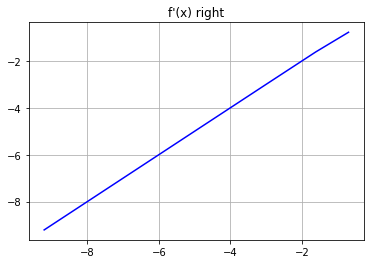

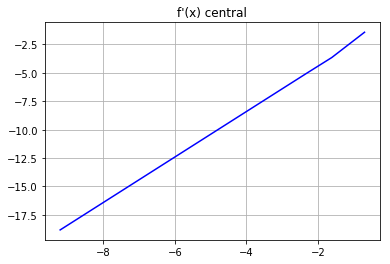

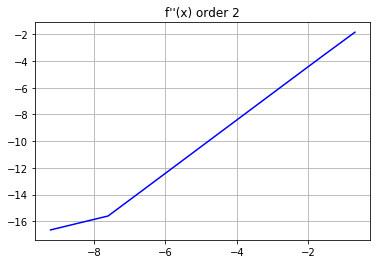

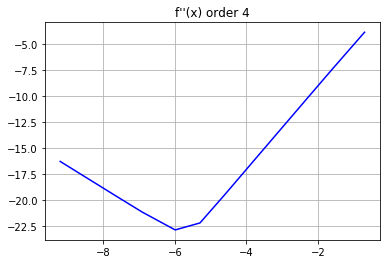

In [23]:
print(err_right, err_first, err_second_2, err_second_4)
plt.figure(1)
plt.plot(
    h,
    err_right,
    'b',
)
plt.title("f'(x) right")
plt.grid(True)
plt.figure(2)
plt.plot(
    h,
    err_first,
    'b',
)
plt.title("f'(x) central")
plt.grid(True)
plt.figure(3)
plt.plot(
    h,
    err_second_2,
    'b',
)

plt.title("f''(x) order 2")
plt.grid(True)
plt.figure(4)
plt.plot(
    h,
    err_second_4,
    'b',
)
plt.title("f''(x) order 4")
plt.grid(True)
# plt.figure(2)
# plt.plot(
#     normal_net_plot['x'],
#     normal_net_plot['Ln'],
#     'k',
#     normal_net_inter['x'],
#     normal_net_inter['Ln'],
#     'bo'
# )
# plt.figure(4)
# plt.plot(
#     chebyshev_net_plot['x'],
#     chebyshev_net_plot['Ln'],
#     'k'
# )